### Making Pedictions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()

house_prices['is_centralair'] = pd.get_dummies(house_prices.centralair, drop_first = True)
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,is_centralair
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,2,2008,WD,Normal,208500,1
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,5,2007,WD,Normal,181500,1
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,None,None,None,0,9,2008,WD,Normal,223500,1
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,None,None,None,0,2,2006,WD,Abnorml,140000,1
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,None,None,None,0,12,2008,WD,Normal,250000,1


In [5]:
new_house_prices = pd.concat([house_prices[['saleprice','overallqual','totalbsmtsf'
                                            ,'firstflrsf','grlivarea','garagecars','garagearea','is_centralair']]
                                           ,pd.get_dummies(house_prices['mszoning'], prefix = 'mszoning'
                                                           , drop_first = True)], axis = 1)
new_house_prices
new_house_prices.head()

,saleprice,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea,is_centralair,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,208500,7,856,856,1710,2,548,1,0,0,1,0
1,181500,6,1262,1262,1262,2,460,1,0,0,1,0
2,223500,7,920,920,1786,2,608,1,0,0,1,0
3,140000,7,756,961,1717,3,642,1,0,0,1,0
4,250000,8,1145,1145,2198,3,836,1,0,0,1,0


To address the issue of multicollinearity in categorical variables' or dummy variables' we need to exclude one variable from the mszoning dummy variables from our model.

In [6]:
X = new_house_prices[['overallqual','totalbsmtsf','firstflrsf'
                      ,'grlivarea','garagecars','garagearea', 'is_centralair'
                      , 'mszoning_FV', 'mszoning_RH', 'mszoning_RL']]
Y = new_house_prices['saleprice']

Lets devide the Data into train and test;We will use 75% of the data for training the model and the remaining 25% we will use for testing our model.

In [7]:
X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 445)

Lets fit the training data in to our OLS model;

In [8]:
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     380.9
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:42:09   Log-Likelihood:                -13036.
No. Observations:                1095   AIC:                         2.609e+04
Df Residuals:                    1084   BIC:                         2.615e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.12e+05   6167.100    -18.164      0.000   -1.24e+05   -9.99e+04
overallqual    2.359e+04   1194.860     19.741      0.000    2.12e+04    2.59e+04
totalbsmtsf      15.5207      4.670      3.324      0.001       6.358      24.683
firstflrsf       13.5905      5.425      2.505      0.012       2.945      24.236
grlivarea        40.7112      2.909     13.995      0.000      35.003      46.419
garagecars     1.736e+04   3257.736      5.329      0.000     1.1e+04    2.38e+04
garagearea        2.9549     11.220      0.263      0.792     -19.061      24.971
is_centralair  5000.5653   4654.863      1.074      0.283   -4132.997    1.41e+04
mszoning_FV    2.113e+04   6225.988      3.394      0.001    8913.960    3.33e+04
mszoning_RH    6538.7489   1.01e+04      0.649      0.516   -1.32e+04    2.63e+04
mszoning_RL    2.097e+04   3253.450      6.447      0.000    1.46e+04    2.74e+04
==============================================================================
Omnibus:                      316.256   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22092.607
Skew:                          -0.349   Prob(JB):                         0.00
Kurtosis:                      24.994   Cond. No.                     2.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above result we can see that the R-squared and the adj. R-squares values are 0.778 and 0.776 respectively.

Now that we have trained our model,lets test it using our test data to check it's performance on unobserved data.

In [9]:
X_test = sm.add_constant(X_test)
Y_predicted = results.predict(X_test)

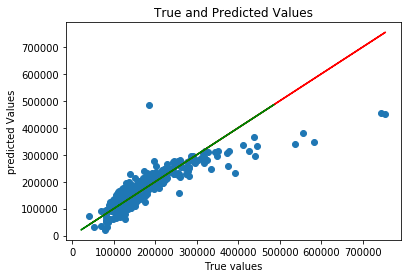

In [10]:
plt.scatter(Y_test, Y_predicted)
plt.plot(Y_test, Y_test, color = 'red')
plt.plot(Y_predicted, Y_predicted, color = 'green')
plt.title('True and Predicted Values')
plt.xlabel('True values')
plt.ylabel("predicted Values");

In [11]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_predicted)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_predicted)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_predicted)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_predicted) / Y_test)) * 100))

Mean absolute error of the prediction is: 26020.922347826512
Mean squared error of the prediction is: 2008473114.4647226
Root mean squared error of the prediction is: 44815.991726890556
Mean absolute percentage error of the prediction is: 14.629005962171371


Based on the values of R-square and R-square the goodness of fit of our model looks satisfactory except the fact that 3 of the 11 features turned out to be insignificant from the results of t-tsest's p-values.

Lets remove those insignificant features and add another features and check once more the performance of our model.

lets add other categorical variables(features) to our model and see if performance is improved.

In [30]:
print(house_prices.select_dtypes(include= 'object').columns)
print('number of categorical variables is:{}'.format(len(house_prices.select_dtypes(include= 'object').columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
number of categorical variables is:43


In [33]:
new_house_prices_1 = pd.concat([house_prices[['overallqual','totalbsmtsf'
                                            ,'firstflrsf','grlivarea','garagecars',]]
                                           ,pd.get_dummies(house_prices['mszoning'], prefix = 'mszoning'
                                                           , drop_first = True)
                                ,pd.get_dummies(house_prices.neighborhood, prefix = 'neighborhood'
                                                , drop_first = True)], axis = 1)

In [34]:
X = new_house_prices_1
Y = house_prices['saleprice']

In [35]:
X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 445)

In [36]:
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     147.8
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:13:46   Log-Likelihood:                -12919.
No. Observations:                1095   AIC:                         2.591e+04
Df Residuals:                    1061   BIC:                         2.608e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.756e+04   1.95e+04     -5.009      0.000   -1.36e+05   -5.93e+04
overallqual           1.772e+04   1253.511     14.135      0.000    1.53e+04    2.02e+04
totalbsmtsf             10.3132      4.289      2.405      0.016       1.898      18.728
firstflrsf              15.0840      5.179      2.913      0.004       4.922      25.246
grlivarea               39.8210      2.917     13.652      0.000      34.098      45.544
garagecars            1.522e+04   1867.454      8.153      0.000    1.16e+04    1.89e+04
mszoning_FV           3.219e+04   1.81e+04      1.774      0.076   -3409.819    6.78e+04
mszoning_RH           2.838e+04   1.82e+04      1.557      0.120   -7392.708    6.42e+04
mszoning_RL           3.951e+04   1.56e+04      2.533      0.011    8907.483    7.01e+04
mszoning_RM           2.247e+04   1.47e+04      1.524      0.128   -6462.110    5.14e+04
neighborhood_Blueste  4165.8541   2.55e+04      0.164      0.870   -4.58e+04    5.42e+04
neighborhood_BrDale  -1097.6837   1.46e+04     -0.075      0.940   -2.98e+04    2.76e+04
neighborhood_BrkSide  1.534e+04   1.08e+04      1.424      0.155   -5801.568    3.65e+04
neighborhood_ClearCr   3.53e+04   1.18e+04      2.984      0.003    1.21e+04    5.85e+04
neighborhood_CollgCr  1.957e+04   9375.606      2.088      0.037    1175.468     3.8e+04
neighborhood_Crawfor   3.62e+04   1.07e+04      3.398      0.001    1.53e+04    5.71e+04
neighborhood_Edwards  1277.1403      1e+04      0.128      0.898   -1.84e+04    2.09e+04
neighborhood_Gilbert  1.598e+04   9953.664      1.605      0.109   -3554.033    3.55e+04
neighborhood_IDOTRR    1.48e+04    1.3e+04      1.136      0.256   -1.08e+04    4.04e+04
neighborhood_MeadowV  1.554e+04   1.51e+04      1.030      0.303   -1.41e+04    4.51e+04
neighborhood_Mitchel  7694.4275   1.04e+04      0.740      0.460   -1.27e+04    2.81e+04
neighborhood_NAmes    4803.9952   9382.509      0.512      0.609   -1.36e+04    2.32e+04
neighborhood_NPkVill -7569.9886   1.61e+04     -0.471      0.638   -3.91e+04     2.4e+04
neighborhood_NWAmes   2290.6733   9920.750      0.231      0.817   -1.72e+04    2.18e+04
neighborhood_NoRidge  6.997e+04   1.09e+04      6.390      0.000    4.85e+04    9.15e+04
neighborhood_NridgHt  6.583e+04   9858.318      6.678      0.000    4.65e+04    8.52e+04
neighborhood_OldTown  2023.8435    1.1e+04      0.184      0.854   -1.96e+04    2.36e+04
neighborhood_SWISU   -3046.4602   1.22e+04     -0.249      0.803    -2.7e+04     2.1e+04
neighborhood_Sawyer   9251.8882   1.01e+04      0.917      0.360   -1.06e+04    2.91e+04
neighborhood_SawyerW  1.032e+04   1.02e+04      1.007      0.314   -9787.537    3.04e+04
neighborhood_Somerst  3.341e+04   1.15e+04      2.894      0.004    1.08e+04    5.61e+04
neighborhood_StoneBr  7.068e+04   1.16e+04      6.108    

In [40]:
house_prices.neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: neighborhood, dtype: int64

In [37]:
X_test = sm.add_constant(X_test)
Y_predicted = results.predict(X_test)

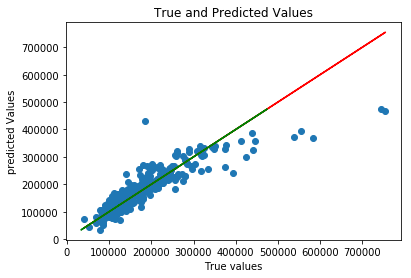

In [38]:
plt.scatter(Y_test, Y_predicted)
plt.plot(Y_test, Y_test, color = 'red')
plt.plot(Y_predicted, Y_predicted, color = 'green')
plt.title('True and Predicted Values')
plt.xlabel('True values')
plt.ylabel("predicted Values");

In [39]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_predicted)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_predicted)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_predicted)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_predicted) / Y_test)) * 100))

Mean absolute error of the prediction is: 24175.828847845118
Mean squared error of the prediction is: 1717222578.8945918
Root mean squared error of the prediction is: 41439.38439328692
Mean absolute percentage error of the prediction is: 13.341638668154552


The model performance was improved except the fact that we have to remove 17 insignifican variables from our model.But before doing so it is a good practice to check if the Gauss Markov assumptions are met.If they are not met we need to work on the model further before interpreting the significance of the coefficients.